# Home Credit Default 

## Data Description

https://www.kaggle.com/c/home-credit-default-risk/data

#### - application_{train|test}.csv:

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

#### - bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### - bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### - POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### - credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

#### - previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

#### - installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

#### - HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.


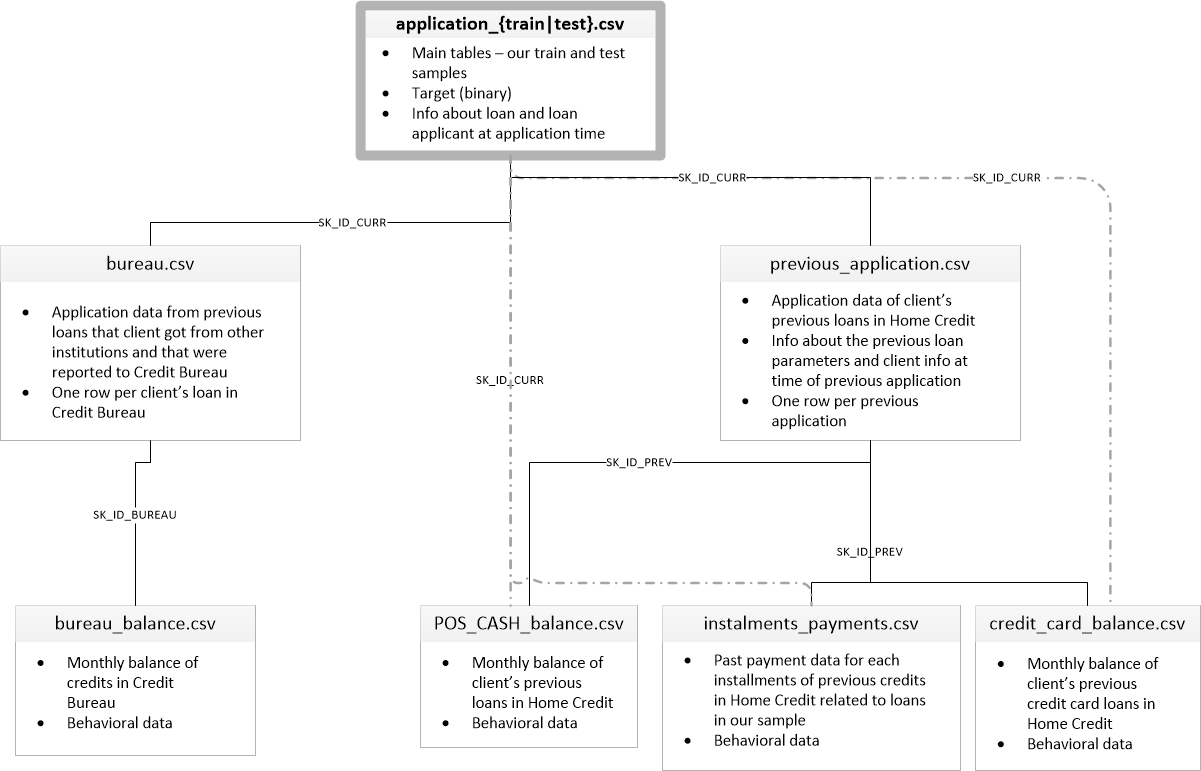

In [7]:
from PIL import Image
import requests
from io import BytesIO
url = 'https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

## Notebook Structutre:

### 1:
    - Exploratory data analysis using only application train dataset
    - Development of machine learning model only with features from train dataset
    - Choose a metric to be optimized 
### 2:
    - Build new features from posh cash balance and repeat the process of exploratory data analysis and train new models

## Import Lib's

In [54]:
import os
from pyspark.sql import SparkSession
import glob
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pyspark.sql.types import StructField,StringType,IntegerType,StructType
spark = SparkSession.builder.appName("Basics").getOrCreate()

## Import Files 

In [10]:
data_application = spark.read.parquet('parquet_files/application_train.parquet',header = True)
data_bureau_balance = spark.read.parquet('parquet_files/bureau_balance.parquet',header = True)
data_posh_balance = spark.read.parquet('parquet_files/POS_CASH_balance.parquet',header = True)
data_credit_card_balance = spark.read.parquet('parquet_files/credit_card_balance.parquet',header = True)
data_bureau = spark.read.parquet('parquet_files/bureau.parquet',header = True)
data_installments_payments = spark.read.parquet('parquet_files/installments_payments.parquet',header = True)
data_previous_applicatin = spark.read.parqbuet('parquet_files/previous_application.parquet',header = True)

## Build Features: Quantity of contract staus in the moment of applciation

In [50]:
data_pandas_posh_balance = data_posh_balance\
.filter( data_posh_balance['MONTHS_BALANCE'] == -1 )\
.groupBy(["SK_ID_CURR"])\
.pivot('NAME_CONTRACT_STATUS')\
.agg({"NAME_CONTRACT_STATUS":"count"})\
.toPandas()